# TP 3: DataStream

## Online_Kmeans

## Part 1 

### 1) Code for Regular Kmeans 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from copy import deepcopy
import pandas as pd 

In [2]:
def regular_kmeans(data, n_clusters, rseed=2):
    
    """
    Input 
    
    data : numerical data as input
    
    n_cluters : number of clusters to define primarily
    
     
    Returns : 
    
    centers : centers of the clusters
    
    labels: assigment of each sample to a cluster
    
    """
    # 1. Randomly choose clusters
    n= data.shape[0]
    rng = np.random.RandomState(rseed)
    i = rng.permutation(n)[:n_clusters]
    centers = data[i]
    
    distances = np.zeros((n,n_clusters))
    
    
    while True:
        
        for i in range(n_clusters):
            
            distances[:,i] = np.linalg.norm(data - centers[i], axis=1)
            
        # Assign all training data to closest center
        labels = np.argmin(distances, axis = 1)
        
        # 2 Find new centers from means of points
        new_centers = np.array([data[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 3 Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

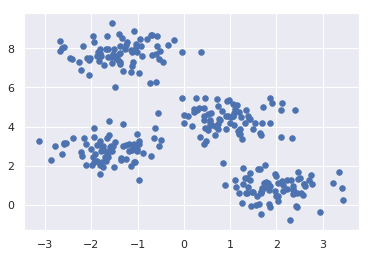

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30);

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

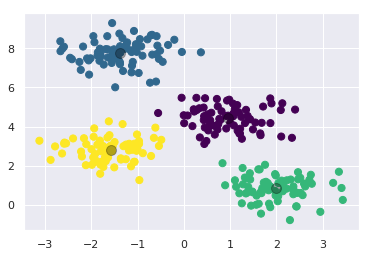

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3)

### 2) Code for Online Kmeans

In [35]:
def online_kmeans(data, n_clusters, eta, verbose = True):
    labels = []
 
    n= data.shape[0]
    centers = data[: n_clusters]
    
    for i in range(n-1):

        new_centers = deepcopy(centers)    
        distances = np.linalg.norm(centers - data[i+1], axis = 1) 
        label = np.argmin(distances)
        print('time : ', i+1, '\ncluster : ', label, '\ndistance :', distances[label],'\n')
        eta_t = 1/ min(eta,i+1)
        new_centers[label] = new_centers[label] +  eta_t * ( data[i+1] - new_centers[label])
    
        labels.append(label)
        centers=new_centers
        
    return new_centers, labels

In [39]:
## Display Clusters on a 2D simulation
plt.figure(figsize=(8,6))
centers, labels = online_kmeans(X, 6, eta = 2, verbose = False)

time :  1 
cluster :  1 
distance : 0.0 

time :  2 
cluster :  2 
distance : 0.0 

time :  3 
cluster :  3 
distance : 0.0 

time :  4 
cluster :  4 
distance : 0.0 

time :  5 
cluster :  5 
distance : 0.0 

time :  6 
cluster :  0 
distance : 2.699506348809449 

time :  7 
cluster :  2 
distance : 0.763535702332382 

time :  8 
cluster :  3 
distance : 1.0212715204218514 

time :  9 
cluster :  3 
distance : 0.5460424595514584 

time :  10 
cluster :  0 
distance : 1.5280367699786352 

time :  11 
cluster :  1 
distance : 1.57164157296387 

time :  12 
cluster :  2 
distance : 0.24008708827922493 

time :  13 
cluster :  1 
distance : 1.004332246524031 

time :  14 
cluster :  4 
distance : 1.9305093498080275 

time :  15 
cluster :  2 
distance : 1.0482618915777258 

time :  16 
cluster :  2 
distance : 0.3203005390069383 

time :  17 
cluster :  5 
distance : 0.9022633834266985 

time :  18 
cluster :  0 
distance : 0.8100497284833525 

time :  19 
cluster :  0 
distance : 0.52245

In [42]:
centers

array([[-1.54544086,  2.94106317],
       [-1.39633282,  8.19100508],
       [ 0.88830206,  4.25194649],
       [-0.43798909,  7.44974715],
       [ 2.3310865 ,  1.36053318],
       [ 1.90112096,  0.07516708]])

### Part 2 

In [12]:
health = pd.read_csv("shealth.csv", sep =";")

In [13]:
health.head()

,Day,Date,Weigth,Steps,Walk (min),Swimming (min),other sports (min),Spent kcal,GPS country
0,W,20/05/2015,"68,4",6620.0,75,0,6,380,33
1,Th,21/05/2015,"68,3",8111.0,70,0,11,452,33
2,F,22/05/2015,"68,7",9283.0,85,40,0,686,33
3,Sa,23/05/2015,"68,6",5995.0,53,0,0,237,33
4,Su,24/05/2015,"68,4",1419.0,12,0,0,71,33


In [14]:
health.dtypes

Day                    object
Date                   object
Weigth                 object
Steps                 float64
Walk (min)              int64
Swimming (min)          int64
other sports (min)      int64
Spent kcal              int64
GPS country             int64
dtype: object

In [15]:
def prepare_data (data): 
    
    
    # Select features relevant for clustering 
    
    clustering_features = ['Steps', 'Walk (min)','Swimming (min)','other sports (min)', 'Spent kcal']
    data_final = data[clustering_features]
    
    '''
    Why those 'clustering_features' ? 
    
    Because the Weigth and the GPS country are not informative on the activity of the user and may add noise to the data
    the algorithm would be tempted to create clusters of users from the same country or having exactly the same phone
    (same weigth) which is not what we want our clustering algorithm to detect. 
    The date in our case is the index of the samples
    The useful information for our usecase  that could be extracted from the 'Date' feature is the WeekofDay. 
    We can possibly add the month.
    
    '''
    # Drop missing values: only one tuple missing Steps value 
    
    data_final.dropna(inplace = True)
    
    # Standardizing the data using expert knowledge
    
    '''
    The readme file provides relevant informations concerning the range of the clustering features.
    This can be used to starndardize the data.
    
    We are provided with :
    
    'Walk(min)' ranges from 30 min for below average users to beyond 90 min for active users
    'Steps' ranges from 3000 for below average users to beyond 9000 for active users
    'Spent kcal' ranges from 150 Kcal for below average users to beyond 450 Kcal for active users
    
    '''
    data_final['Walk (min)'] = (data_final['Walk (min)'] - 30) / (120 - 30)
    data_final['Steps'] = (data_final['Steps'] - 3000) / (12000 - 3000)
    data_final['Spent kcal'] = (data_final['Spent kcal'] - 30) / (120 - 30)
    
    
    return(data_final)
    
    
    
def customized_distance(data):
    
    '''Input: data: data prepared to be fed to the clustering algorithm'''
    
    return 0 
    
    

In [16]:
# apply data preparation to shealth data
health_clust = prepare_data(health)

/home/mejri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mejri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mejri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mejri/anac

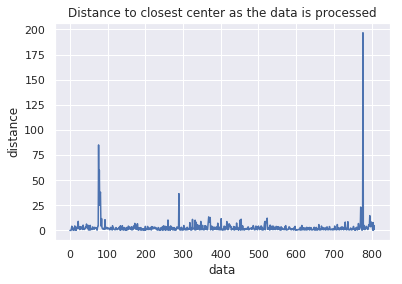

In [17]:
# apply online_kmeans clustering
_ , labels_online = online_kmeans(data = health_clust.values, n_clusters = 4, eta = 20, verbose = False)

In [18]:
clusters_df = pd.DataFrame({'cluster': labels})
clusters_df['cluster'].value_counts()

2    104
0     78
1     60
3     58
Name: cluster, dtype: int64

In [19]:
_ , labels_regular = regular_kmeans(data = health_clust.values, n_clusters = 4)

In [20]:
clusters_df = pd.DataFrame({'cluster': labels})
clusters_df['cluster'].value_counts()

2    104
0     78
1     60
3     58
Name: cluster, dtype: int64